# NetBox Topology Exporter PoC

Initialize parameters

In [167]:
export_site = "DM-Akron"
nb_api_url = 'https://demo.netbox.dev'
nb_api_token = '2155d93c365789cf63577f47b5ebe350be61d4c3'
export_device_roles = ["router", "access-switch", "distribution-switch", "tor-switch"]

Initialize Netbox API client

In [168]:
import pynetbox
nb = pynetbox.api(
    nb_api_url,
    token=nb_api_token,
    threading=True,
)

Create a `devices` list of Devices for the site. Each Device is stored in the list as a dictionary:

```
{
    "id": device.id,
    "type": "device",
    "name": device.name,
    "node_id": <index of this device object in the nodes list>,
}
```

Create an `interfaces` list of Interfaces for the Devices selected above, which have Ethernet connections via Cables. Each Interface is stored in the list as a dictionary:

```
{
    "id": interface.id,
    "type": "interface",
    "name": interface.name,
    "node_id": <index of this interface object in the nodes list>,
}
```

Both Device and Interface dictionary objects are also stored in a common `nodes` list, to create unique IDs to be later used when creating a graph object with them as nodes.

Also, for quick indexing, create separate lists of Device, Interface and Cable IDs.

In [169]:
s = nb.dcim.sites.get(name=export_site)
nodes, devices, interfaces = [], [], []
device_ids, interface_ids, cable_ids = [], [], []
for device in list(nb.dcim.devices.filter(site_id=s.id,role=export_device_roles)):
    d = {
        "id": device.id,
        "type": "device",
        "name": device.name,
        "node_id": -1,
    }
    nodes.append(d)
    d["node_id"] = len(nodes) - 1
    devices.append(d)
    device_ids.append(device.id) # index of the device in the devices list will match its ID index in device_ids list
    for interface in list(nb.dcim.interfaces.filter(device_id=device.id)):
        if "base" in interface.type.value and interface.cable: # only connected ethernet interfaces
            print(device.name, ":", interface, ":", interface.type.value)
            i = {
                "id": interface.id,
                "type": "interface",
                "name": interface.name,
                "node_id": -1,
            }
            nodes.append(i)
            i["node_id"] = len(nodes) - 1
            interfaces.append(i)
            interface_ids.append(interface.id) # index of the interface in the interfaces list will match its ID index in interface_ids list
            cable_ids.append(interface.cable.id)

dmi01-akron-rtr01 : GigabitEthernet0/0/0 : 1000base-x-sfp
dmi01-akron-rtr01 : GigabitEthernet0/0/1 : 1000base-t
dmi01-akron-rtr01 : GigabitEthernet0/1/0 : 1000base-t
dmi01-akron-rtr01 : GigabitEthernet0/1/1 : 1000base-t
dmi01-akron-sw01 : GigabitEthernet1/0/1 : 1000base-t
dmi01-akron-sw01 : GigabitEthernet1/0/2 : 1000base-t


Filter Cables list to only those that are interconnecting Devices. Leave Circuits out.

Create a Graph object representing ownership of Interfaces by Devices, and interconnections between Interfaces.

In [170]:
import networkx as nx
G = nx.Graph()
N = nx.Graph() # graph with names as IDs for quick visual validation only

for cable in list(nb.dcim.cables.filter(id=cable_ids)):
    if len(cable.a_terminations) == 1 and len(cable.b_terminations) == 1:
        int_a = cable.a_terminations[0]
        int_b = cable.b_terminations[0]
        if isinstance(int_a, pynetbox.models.dcim.Interfaces) and isinstance(int_b, pynetbox.models.dcim.Interfaces):
            print("{}:{} <> {}:{}".format(int_a.device,int_a,int_b.device,int_b))
            d_a = devices[device_ids.index(int_a.device.id)]
            d_b = devices[device_ids.index(int_b.device.id)]
            G.add_nodes_from([
                (d_a["node_id"], {"side": "a", "type": "device", "device": d_a}),
                (d_b["node_id"], {"side": "b", "type": "device", "device": d_b}),
            ])
            N.add_nodes_from([
                (d_a["name"], {"side": "a", "type": "device", "device": d_a}),
                (d_b["name"], {"side": "b", "type": "device", "device": d_b}),
            ])
            i_a = interfaces[interface_ids.index(int_a.id)]
            i_b = interfaces[interface_ids.index(int_b.id)]
            G.add_nodes_from([
                (i_a["node_id"], {"side": "a", "type": "interface", "interface": i_a}),
                (i_b["node_id"], {"side": "b", "type": "interface", "interface": i_b}),
            ])
            N.add_nodes_from([
                (i_a["name"], {"side": "a", "type": "interface", "interface": i_a}),
                (i_b["name"], {"side": "b", "type": "interface", "interface": i_b}),
            ])
            G.add_edges_from([
                (d_a["node_id"], i_a["node_id"]),
                (d_b["node_id"], i_b["node_id"]),
            ])
            N.add_edges_from([
                (d_a["name"], i_a["name"]),
                (d_b["name"], i_b["name"]),
            ])
            G.add_edges_from([
                (i_a["node_id"], i_b["node_id"]),
            ])
            N.add_edges_from([
                (i_a["name"], i_b["name"]),
            ])
print(G)

dmi01-akron-rtr01:GigabitEthernet0/1/0 <> dmi01-akron-sw01:GigabitEthernet1/0/1
dmi01-akron-rtr01:GigabitEthernet0/1/1 <> dmi01-akron-sw01:GigabitEthernet1/0/2
Graph with 6 nodes and 6 edges


Visualize the graphs for quick validation

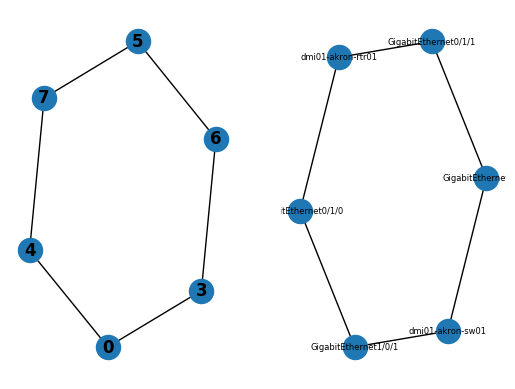

In [171]:
import matplotlib.pyplot as plt
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax1 = plt.subplot(122)
nx.draw(N, with_labels=True, font_size='6')